In [1]:
import pandas as pd
import matplotlib as mt
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import LabelEncoder
from collections import Counter
pd.set_option('display.max_rows', 30)
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score

In [2]:
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 20} 
axes= {'linewidth':2}
mt.rc('axes',**axes)
mt.rc('font', **font)

In [3]:
SEED=42
np.random.seed(SEED)

In [4]:
df = pd.read_excel('INITIAL DATA12.xlsx')
df.info()
df1=df.drop(['PHASE'],axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111 entries, 0 to 110
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   DELTA_R                  111 non-null    float64
 1   DELTA_Hmix               111 non-null    float64
 2   DELTA_Smix               111 non-null    float64
 3   Delta electronegativity  111 non-null    float64
 4   VEC                      111 non-null    float64
 5   PHASE                    111 non-null    object 
dtypes: float64(5), object(1)
memory usage: 5.3+ KB


In [5]:
df.isna().sum()

DELTA_R                    0
DELTA_Hmix                 0
DELTA_Smix                 0
Delta electronegativity    0
VEC                        0
PHASE                      0
dtype: int64

In [6]:
df1.corr()

,DELTA_R,DELTA_Hmix,DELTA_Smix,Delta electronegativity,VEC
DELTA_R,1.000000,-0.074442,0.144289,0.278089,-0.355255
DELTA_Hmix,-0.074442,1.000000,-0.255454,-0.014703,0.058033
DELTA_Smix,0.144289,-0.255454,1.000000,0.104955,-0.042704
Delta electronegativity,0.278089,-0.014703,0.104955,1.000000,-0.182511
VEC,-0.355255,0.058033,-0.042704,-0.182511,1.000000


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import linear_model

In [8]:
X = df.drop(['PHASE'],axis=1)
y=df['PHASE']

#### 1-2-2 Feature extraction

In [9]:
from numpy import mean
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

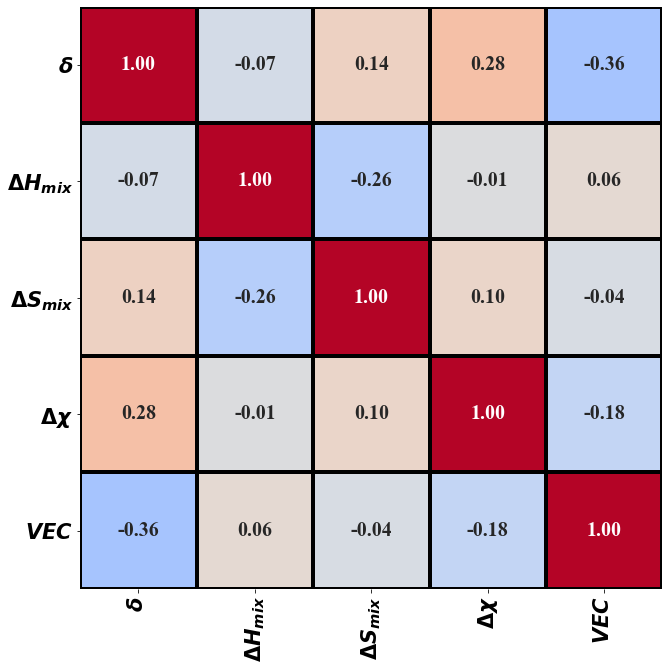

In [10]:
def HeatMap(df,x=True):
        correlations = df1.corr()
        ## Create color map ranging between two colors
        cmap = sns.diverging_palette(220, 10, as_cmap=True)
        fig, ax = plt.subplots(figsize=(10, 10))
        fig = sns.heatmap(correlations, cmap='coolwarm', center=0, fmt='.2f',square=True, linewidths=3,linecolor='k',annot=x,cbar=False)
        plt.rcParams.update({"font.size":30})
        plt.rcParams["font.family"]="Times New Roman"
        plt.rcParams["font.weight"]= 'bold'
        xticklabels=['$\delta $','$\Delta H_{mix}$','$\Delta S_{mix}$','$\Delta \chi$','$VEC$']
        yticklabels=['$\delta $','$\Delta H_{mix}$','$\Delta S_{mix}$','$\Delta \chi$','$VEC$']
        fig.set_xticklabels(xticklabels, rotation = 90, fontsize = 21,fontweight='bold')
        fig.set_yticklabels(yticklabels, rotation = 0,ha='right', fontsize = 21,fontweight='bold')
        plt.tight_layout()
        plt.show()
        figure = fig.get_figure()    
        figure.savefig('svm_conf12.jpg',dpi=1000)
HeatMap(df,x=True)

In [11]:
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 15} 
axes= {'linewidth':2}
mt.rc('axes',**axes)
mt.rc('font', **font)

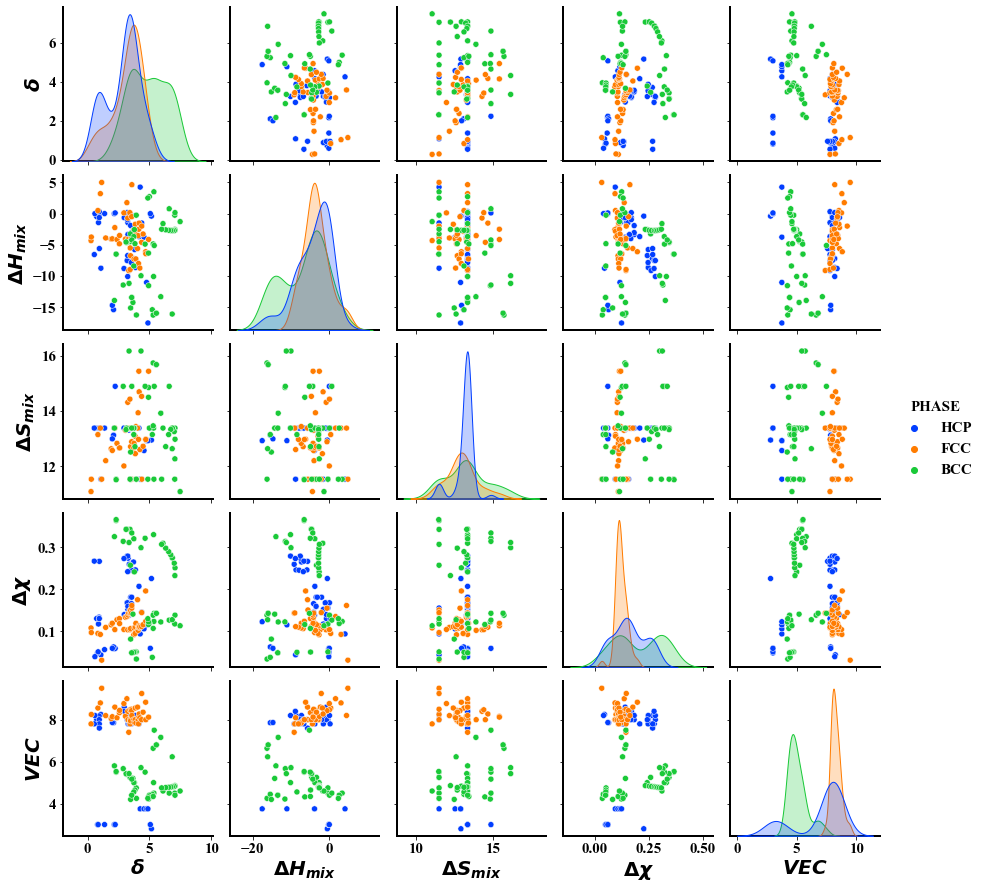

In [12]:
g=sns.pairplot(data=df,hue='PHASE',palette='bright')
replacements = ({'DELTA_R': '$\delta $', 'DELTA_Hmix': '$\Delta H_{mix}$','DELTA_Smix':'$\Delta S_{mix}$' ,'Delta electronegativity': '$\Delta \chi$', 'VEC': '$VEC$',
                0:'BCC',1:'FCC',2:'HCP'})
for i in range(5):
    for j in range(5):
        xlabel = g.axes[i][j].get_xlabel()
        ylabel = g.axes[i][j].get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel],fontweight='bold',fontsize=20)
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel],fontweight='bold',fontsize=20)
for i in range(len(g.fig.get_children()[-1].texts)):
    label = g.fig.get_children()[-1].texts[i].get_text()
    if label in replacements.keys():
        g.fig.get_children()[-1].texts[i].set_text(replacements[label])
g._legend.set_bbox_to_anchor((1, 0.5))
plt.savefig('pairplo12.jpg',dpi=1000)

In [11]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()

In [12]:
X_sm1 , y_sm1 = smote.fit_sample(X,y)
X_sm , y_sm = X_sm1 , y_sm1

In [13]:
print("Before SMOTE: ", Counter(y))
print("After SMOTE: ", Counter(y_sm))

Before SMOTE:  Counter({'BCC': 50, 'FCC': 42, 'HCP': 19})
After SMOTE:  Counter({'HCP': 50, 'FCC': 50, 'BCC': 50})


In [14]:
scaler = MinMaxScaler()
X_sm = scaler.fit_transform(X_sm)

Now, dataset is balanced. Let's see how works comparing Baseline model:

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.35, random_state=SEED)

In [16]:
X_train.shape

(97, 5)

### __2__ Build Model & Validate
#### 2-1 Baseline Model

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline

In [18]:
# define Classifiers
log = LogisticRegression()  
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier()
rtree = RandomForestClassifier()
svm = SVC()
nb = GaussianNB()
gbc = GradientBoostingClassifier()
etree = ExtraTreesClassifier()

In [19]:
# define a function that uses pipeline to impelement data transformation and fit with model then cross validate
def baseline_model(model_name):
    model = model_name
    steps = list()
    steps.append(('ss', StandardScaler() ))
    steps.append(('ml', model))
    pipeline = Pipeline(steps=steps)
    cv = RepeatedStratifiedKFold(n_splits=5,n_repeats=3, random_state=SEED)
    scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    scores=100*scores
    print(model,'Accuracy: %.3f' % (mean(scores)))
    print('Std: %.3f'%  np.std(scores))

In [20]:
%%time
baseline_model(log)
baseline_model(knn)
baseline_model(dtree)
baseline_model(rtree)
baseline_model(svm)
baseline_model(nb)
baseline_model(gbc)
baseline_model(etree)

LogisticRegression() Accuracy: 77.947
Std: 8.640
KNeighborsClassifier() Accuracy: 76.579
Std: 8.908
DecisionTreeClassifier() Accuracy: 84.842
Std: 8.519
RandomForestClassifier() Accuracy: 85.930
Std: 7.895
SVC() Accuracy: 84.509
Std: 8.096
GaussianNB() Accuracy: 82.754
Std: 7.441
GradientBoostingClassifier() Accuracy: 85.912
Std: 7.731
ExtraTreesClassifier() Accuracy: 90.719
Std: 5.489
Wall time: 6.45 s


#### 2-2 Hyper-parameters
##### 2-2-1 Grid search

In [21]:
from sklearn.model_selection import GridSearchCV

In [31]:
%%time
#logistic regression classifier

#define hyper parameters and ranges
param_grid_log = [{'C': [0.1, 1, 10], 'solver': ['lbfgs', 'liblinear'], 
                   'max_iter':[100, 300]}]
#apply gridsearch
grid_log  = GridSearchCV(log, param_grid=param_grid_log, cv=5)
#fit model with grid search
grid_log.fit(X_train, y_train)
print('The best parameters for log classifier: ', grid_log.best_params_)

The best parameters for log classifier:  {'C': 1, 'max_iter': 100, 'solver': 'liblinear'}
Wall time: 461 ms


In [32]:
%%time
#kNN classifier

#define hyper parameters and ranges
param_grid_knn = [{'n_neighbors': [2, 3, 4, 6, 8, 10], 'weights': [ 'uniform', 'distance'], 
                   'metric': ['euclidean', 'manhattan', 'minkowski']}]
#apply gridsearch
grid_knn  = GridSearchCV(knn, param_grid=param_grid_knn, cv=4)
#fit model with grid search
grid_knn.fit(X_train, y_train)
print('The best parameters for knn classifier: ', grid_knn.best_params_)

The best parameters for knn classifier:  {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'}
Wall time: 591 ms


In [33]:
%%time
#decision tree classifier

#define hyper parameters and ranges
param_grid_dtree = [{'max_depth': [ 15, 20, 25, 30], 'criterion': ['gini',  'entropy']}]
#apply gridsearch
grid_dtree  = GridSearchCV(dtree, param_grid=param_grid_dtree, cv=4)
#fit model with grid search
grid_dtree.fit(X_train, y_train)
print('The best parameters for dtree classifier: ', grid_dtree.best_params_)

The best parameters for dtree classifier:  {'criterion': 'gini', 'max_depth': 25}
Wall time: 70.7 ms


In [95]:
%%time
#random forest classifier

#define hyper parameters and ranges
param_grid_rtree = [{'max_depth': [5, 10, 15, 20], 'n_estimators':[100,300,500] ,
                     'criterion': ['gini',  'entropy']}]
#apply gridsearch
grid_rtree  = GridSearchCV(rtree, param_grid=param_grid_rtree, cv=4)
#fit model with grid search
grid_rtree.fit(X_train, y_train)
print('The best parameters for rtree classifier: ', grid_rtree.best_params_)

The best parameters for rtree classifier:  {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 500}
Wall time: 54.4 s


In [44]:
%%time
#SVM classifier

#define hyper parameters and ranges
param_grid_svm = [{'C': [100, 50, 10, 1.0, 0.1, 0.01], 'gamma': ['scale'], 
                   'kernel': ['poly', 'rbf', 'sigmoid'] }]
#apply gridsearch
grid_svm  = GridSearchCV(svm, param_grid=param_grid_svm, cv=4)
#fit model with grid search
grid_svm.fit(X_train, y_train)
print('The best parameters for svm classifier: ', grid_svm.best_params_)

The best parameters for svm classifier:  {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Wall time: 166 ms


In [37]:
%%time
#gbc classifier
#define hyper parameters and ranges
param_grid_gbc = [{'learning_rate': [0.1, 1], 'n_estimators':[200,350,500]}]
#apply gridsearch
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=SEED)
grid_gbc  = GridSearchCV(gbc, param_grid=param_grid_gbc, cv=cv)
#fit model with grid search
grid_gbc.fit(X_train, y_train)
print('The best parameters for gbc classifier: ', grid_gbc.best_params_)

The best parameters for gbc classifier:  {'learning_rate': 0.1, 'n_estimators': 200}
Wall time: 29.6 s


In [96]:
%%time
#etree classifier
#define hyper parameters and ranges
param_grid_etree = [{'max_depth': [15, 20, 25, 30, 35], 'n_estimators':[200,350,500] , 
                     'criterion': ['gini',  'entropy']}]
#apply gridsearch
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=SEED)
grid_etree  = GridSearchCV(etree, param_grid=param_grid_etree, cv=cv)
#fit model with grid search
grid_etree.fit(X_train, y_train)
print('The best parameters for etree classifier: ', grid_etree.best_params_)

The best parameters for etree classifier:  {'criterion': 'gini', 'max_depth': 30, 'n_estimators': 350}
Wall time: 2min 26s


##### Build model objects with optimized hyper-paramters and run baseline model with hyper-parameters

In [23]:
# define Classifiers with hyper params
log_hp = LogisticRegression(C = 0.1, solver = 'liblinear', max_iter= 100 ) 
knn_hp = KNeighborsClassifier(metric = 'manhattan', n_neighbors=4,weights= 'distance')
dtree_hp = DecisionTreeClassifier(criterion = 'entropy', max_depth=30)
rtree_hp = RandomForestClassifier(criterion='gini', max_depth=5, n_estimators=500)
svm_hp = SVC(C=100, gamma= 'scale', kernel='rbf'  )  
nb_hp = GaussianNB()
gbc_hp = GradientBoostingClassifier(learning_rate=1, n_estimators=350)
etree_hp = ExtraTreesClassifier(criterion='gini', max_depth=25, n_estimators=350)

In [34]:
%%time
baseline_model(log_hp)
baseline_model(knn_hp)
baseline_model(dtree_hp)
baseline_model(rtree_hp)
baseline_model(svm_hp)
baseline_model(nb_hp)
baseline_model(gbc_hp)
baseline_model(etree_hp)

LogisticRegression(C=0.1, solver='liblinear') Accuracy: 77.596
Std: 9.133
KNeighborsClassifier(metric='manhattan', n_neighbors=4, weights='distance') Accuracy: 87.263
Std: 6.053
DecisionTreeClassifier(criterion='entropy', max_depth=30) Accuracy: 86.561
Std: 7.430
RandomForestClassifier(max_depth=5, n_estimators=500) Accuracy: 87.965
Std: 7.069
SVC(C=100) Accuracy: 87.912
Std: 9.141
GaussianNB() Accuracy: 82.754
Std: 7.441
GradientBoostingClassifier(learning_rate=1, n_estimators=350) Accuracy: 86.228
Std: 8.712
ExtraTreesClassifier(max_depth=25, n_estimators=350) Accuracy: 91.035
Std: 6.230
Wall time: 6.3 s


#### __3- Model Evaluation-1__


In [35]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_recall_fscore_support

In [25]:
# single example to model evaluation metrices one by one
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=SEED)
model_et=etree_hp
model_et.fit(X_train, y_train)
y_pred_et = model_et.predict(X_test)
predictions=y_pred_et

In [26]:
cm=confusion_matrix(y_test, y_pred_et)
cm

NameError: name 'confusion_matrix' is not defined

In [51]:
y_test=np.asarray((y_test))
y_test

array(['BCC', 'HCP', 'FCC', 'BCC', 'BCC', 'FCC', 'BCC', 'HCP', 'BCC',
       'BCC', 'BCC', 'HCP', 'FCC', 'HCP', 'FCC', 'FCC', 'BCC', 'BCC',
       'FCC', 'HCP', 'FCC', 'HCP', 'FCC', 'HCP', 'HCP', 'HCP', 'BCC',
       'HCP', 'FCC', 'FCC', 'FCC', 'HCP', 'BCC', 'HCP', 'FCC', 'HCP',
       'FCC', 'FCC', 'HCP', 'FCC', 'HCP', 'BCC', 'BCC', 'HCP', 'HCP',
       'BCC', 'HCP', 'HCP', 'BCC', 'BCC', 'BCC', 'BCC', 'BCC'],
      dtype=object)

In [52]:
y_pred_et

array(['BCC', 'HCP', 'FCC', 'BCC', 'BCC', 'FCC', 'BCC', 'HCP', 'BCC',
       'BCC', 'BCC', 'HCP', 'FCC', 'HCP', 'FCC', 'FCC', 'BCC', 'BCC',
       'FCC', 'HCP', 'FCC', 'HCP', 'FCC', 'HCP', 'HCP', 'HCP', 'BCC',
       'FCC', 'FCC', 'FCC', 'FCC', 'HCP', 'BCC', 'HCP', 'FCC', 'FCC',
       'FCC', 'FCC', 'HCP', 'FCC', 'HCP', 'BCC', 'BCC', 'HCP', 'FCC',
       'BCC', 'FCC', 'HCP', 'BCC', 'BCC', 'FCC', 'BCC', 'BCC'],
      dtype=object)

In [53]:
print(classification_report(y_test, y_pred_et))

              precision    recall  f1-score   support

         BCC       1.00      0.95      0.97        19
         FCC       0.75      1.00      0.86        15
         HCP       1.00      0.79      0.88        19

    accuracy                           0.91        53
   macro avg       0.92      0.91      0.90        53
weighted avg       0.93      0.91      0.91        53



In [54]:
group_counts = ['{0:0.0f}'.format(value) for value in (cm.flatten())]
group_percentages = ['{0:.2%}'.format(value) for value in (cm.flatten()/np.sum(cm))]
labels = ['{v1} \n {v2} ' for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)

In [195]:
labels = (np.asarray(["{0}\n{1:.2f}".format(text,data) for text, data in zip(text.flatten(), data.flatten())])).reshape(4,6)

NameError: name 'text' is not defined

In [137]:
group_percentages

['33.96%',
 '1.89%',
 '0.00%',
 '0.00%',
 '28.30%',
 '0.00%',
 '1.89%',
 '3.77%',
 '30.19%']

In [ ]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
fig, ax = plt.subplots(figsize=(7, 7))
df_cm = pd.DataFrame(cm)
fig = sns.heatmap(df_cm, cmap="Blues",annot=labels,fmt='',annot_kws={"size": 25},square=True,linewidth=3,linecolor='k',cbar=False)
plt.rcParams.update({"font.size":25})
plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["font.weight"]= 'bold'
xticklabels=['BCC','FCC','HCP']
yticklabels=['BCC','FCC','HCP']
fig.set_xticklabels(xticklabels, rotation = 90, fontsize = 20,fontweight='bold')
fig.set_yticklabels(yticklabels, rotation = 0,ha='right', fontsize = 20,fontweight='bold')
plt.ylabel('Actual Phase',fontsize=22, fontweight='bold')
plt.xlabel('Predicted Phase',fontsize=22, fontweight='bold')
plt.tight_layout()
plt.show()
figure = fig.get_figure()    
figure.savefig('confusiion.jpg',dpi=1000)

__main__
_test_cm: test function with confusion matrix done
and pause


<ipython-input-55-5259917580da>:38: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  per_ok_s = ['%.2f%%'%(per_ok), '100%'] [per_ok == 100]


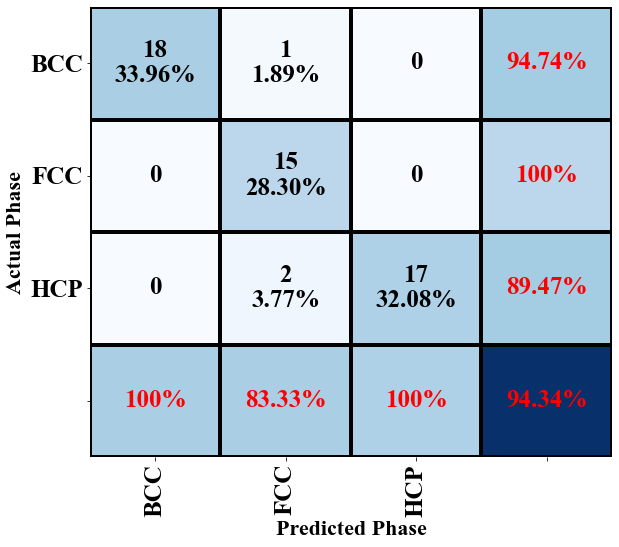

In [55]:
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.collections import QuadMesh
import seaborn as sns
def get_new_fig(fn, figsize=[9,9]):
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()   #Get Current Axis
    ax1.cla() # clear existing plot
    return fig1, ax1
def configcell_text_and_colors(array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=1):
    text_add = []; text_del = [];
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][-1]
    per = (float(cell_val) / tot_all) * 100
    curr_column = array_df[:,col]
    ccl = len(curr_column)
#last line  and/or last column
    if(col == (ccl - 1)) or (lin == (ccl - 1)):
    #tots and percents
        if(cell_val != 0):
            if(col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(col == ccl - 1):
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(lin == ccl - 1):
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ['%.2f%%'%(per_ok), '100%'] [per_ok == 100]

        #text to DEL
        text_del.append(oText)

        #text to ADD
        font_prop = fm.FontProperties(weight='bold', size=fz)
        text_kwargs = dict(color='r', ha="center", va="center", gid='sum', fontproperties=font_prop)
        lis_txt = [per_ok_s]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy(); dic['color'] = 'r'; lis_kwa.append(dic);
        dic = text_kwargs.copy(); dic['color'] = 'r'; lis_kwa.append(dic);
        lis_pos = [(oText._x, oText._y), (oText._x, oText._y), (oText._x, oText._y+0.1)]
        for i in range(len(lis_txt)):
            newText = dict(x=lis_pos[i][0], y=lis_pos[i][1], text=lis_txt[i], kw=lis_kwa[i])
            text_add.append(newText)
        #print '\n'
        

    else:
        if(per > 0):
            txt = '%s\n%.2f%%' %(cell_val, per)
        else:
            if(show_null_values == 0):
                txt = ''
            elif(show_null_values == 1):
                txt = '0'
            else:
                txt = '0\n0.0%'
        oText.set_text(txt)

        #main diagonal
        if(col == lin):
            #set color of the textin the diagonal to white
            oText.set_color('k')
        else:
            oText.set_color('k')

    return text_add, text_del

def insert_totals(df_cm):
    """ insert total column and line (the last ones) """
    Sum_Col = []
    for c in df_cm.columns:
        Sum_Col.append( df_cm[c].sum() )
    Sum_Row = []
    for item_line in df_cm.iterrows():
        Sum_Row.append( item_line[1].sum() )
    df_cm['Sum_Row'] = Sum_Row
    Sum_Col.append(np.sum(Sum_Row))
    df_cm.loc['Sum_Col'] = Sum_Col
def pretty_plot_confusion_matrix(df_cm, annot=True, cmap="orange", fmt='.2f', fz=25,
      lw=3, cbar=False, figsize=[9,8], show_null_values=True, pred_val_axis='x'):
    if(pred_val_axis in ('col', 'x')):
        xlbl = 'Predicted Phase'
        ylbl = 'Actual Phase'
    else:
        xlbl = 'Actual Phase'
        ylbl = 'Predicted Phase'
        df_cm = df_cm.T
    insert_totals(df_cm)
    fig, ax1 = get_new_fig('Conf matrix default', figsize)
    ax = sns.heatmap(df_cm, annot=annot, annot_kws={"size": fz}, linewidths=lw, ax=ax1,
                    cbar=cbar, cmap='Blues', linecolor='k', fmt=fmt)
    xticklabels=['BCC','FCC','HCP','']
    yticklabels=['BCC','FCC','HCP','']
    #set ticklabels rotation
    ax.set_xticklabels(xticklabels, rotation = 90, fontsize = 25)
    ax.set_yticklabels(yticklabels, rotation = 0, fontsize = 25)
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    #face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()
    #iter in text elements
    array_df = np.array( df_cm.to_records(index=False).tolist() )
    text_add = []; text_del = [];
    posi = -1 #from left to right, bottom to top.
    for t in ax.collections[0].axes.texts: #ax.texts:
        pos = np.array( t.get_position()) - [0.5,0.5]
        lin = int(pos[1]); col = int(pos[0]);
        posi += 1
        txt_res = configcell_text_and_colors(array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values)
        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])
    for item in text_del:
        item.remove()
    for item in text_add:
        ax.text(item['x'], item['y'], item['text'], **item['kw'])
    ax.set_xlabel(xlbl,fontweight='bold',fontsize=22)
    ax.set_ylabel(ylbl,fontweight='bold',fontsize=22)
    plt.tight_layout()
    plt.show()
    figure =ax.get_figure()    
    figure.savefig('svm_conf.jpg',dpi=1000,bbox_inches='tight')
def plot_confusion_matrix_from_data(y_test, predictions, columns=None, annot=True, cmap="orange",
      fmt='.2f', fz=25, lw=2,linecolor='k', cbar=False, figsize=[8,8], show_null_values=True, pred_val_axis='lin'):
    from sklearn.metrics import confusion_matrix
    from pandas import DataFrame
    if(not columns):
        from string import ascii_uppercase
        columns = ['class %s' %(i) for i in list(ascii_uppercase)[0:len(np.unique(y_test))]]
    confm = confusion_matrix(y_test, predictions)
    cmap = 'Oranges';
    fz = 20;
    figsize=[9,9];
    show_null_values = 1
    df_cm = DataFrame(confm, index=columns, columns=columns)
    pretty_plot_confusion_matrix(df_cm, fz=fz,linecolor='k', cmap=cmap, figsize=figsize, show_null_values=show_null_values, pred_val_axis=pred_val_axis)
def _test_cm():
    array = np.array( [[18,1,0],
                      [0,15,0],
                      [0,2,17]])
    df_cm = DataFrame(array, index=range(1,4), columns=range(1,4))
    cmap = 'orange'
    pretty_plot_confusion_matrix(df_cm, cmap=cmap)
    
if(__name__ == '__main__'):
    print('__main__')
    print('_test_cm: test function with confusion matrix done\nand pause')
    _test_cm()

In [57]:
log1 = LogisticRegression(C = 0.1, solver = 'liblinear', max_iter= 100 ) 
knn1 = KNeighborsClassifier(metric = 'manhattan', n_neighbors=4,weights= 'distance')
dtree1 = DecisionTreeClassifier(criterion = 'entropy', max_depth=30)
rtree1 = RandomForestClassifier()
svm1 = SVC(C=100, gamma= 'scale', kernel='poly'  )  
nb1 = GaussianNB()
gbc1= GradientBoostingClassifier(learning_rate=1, n_estimators=350)
etree1 = ExtraTreesClassifier(criterion='gini', max_depth=25, n_estimators=350)

In [61]:
%%time
models = []
models.append(('Log-Reg' , log1))
models.append(('KNN', knn1))
models.append(('D-Tree', dtree1))
models.append(('RF', rtree1))
models.append(('SVM', svm1))
models.append(('NB',  nb1))
models.append(('GBC', gbc1))
models.append(('E-Tree', etree1))
results = []
names = []
scoring =  ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
for name, model in models:
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=SEED)
    cv_results = cross_validate(model, X_train, y_train, cv=cv,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    results.append(name)

Wall time: 18.1 s


In [62]:
results =  results[::2]

In [63]:
test_acc = []
for i in range (len(names)):
    test_acc.append(results[i]['test_accuracy'].mean())    
test_f1 = []
for i in range (len(names)):
    test_f1.append(results[i]['test_f1_macro'].mean())      
test_pre = []
for i in range (len(names)):
    test_pre.append(results[i]['test_precision_macro'].mean())
test_rec = []
for i in range (len(names)):
    test_rec.append(results[i]['test_recall_macro'].mean())

In [178]:
test_acc=[0.74,0.79,0.90,0.92,0.79,0.77,0.91,0.94]
test_pre=[0.75,0.82,0.91,0.92,0.82,0.78,0.92,0.94]
test_rec=[0.74,0.79,0.91,0.92,0.79,0.77,0.91,0.94]
test_f1=[0.72,0.80,0.91,0.92,0.80,0.76,0.91,0.94]

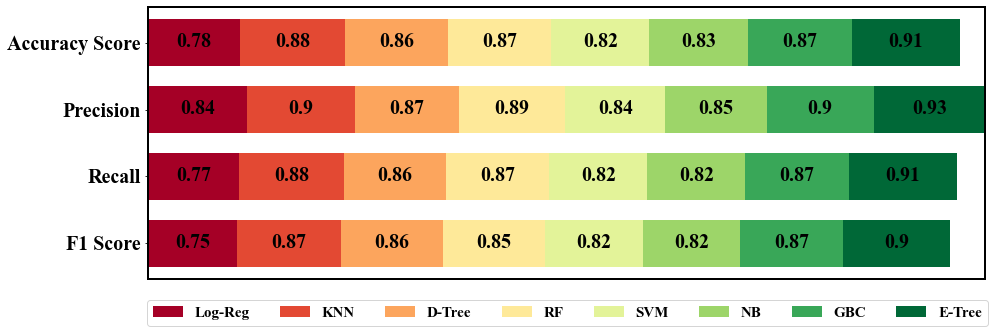

In [64]:
category_names = names
result_data = {"Accuracy Score": test_acc, 'Precision': test_pre, 'Recall':    test_rec,'F1 Score':    test_f1  }

def survey(result_data, category_names):   
    labels = list(result_data.keys())
    data = np.array(list(result_data.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('RdYlGn')(
        np.linspace(0, 1, data.shape[1]))
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())
    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.7,
                label=colname, color=color)
        xcenters = starts + widths / 2
        r, g, b, _ = color
        text_color =  'k'
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            ax.text(x, y, str(np.around(c,decimals = 2)), ha='center', va='center',
                    color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(-0.01, -0.20),
              loc='lower left', fontsize='15')
    fig.savefig('Different Metrics Average.jpg', dpi=1000,bbox_inches='tight')
    return fig, ax
survey(result_data, category_names)
plt.show()
#  np.around(recall, decimals = 2)

In [63]:
import numpy as np

Feature: 0, Score: 0.18753
Feature: 1, Score: 0.12539
Feature: 2, Score: 0.10947
Feature: 3, Score: 0.18589
Feature: 4, Score: 0.39173


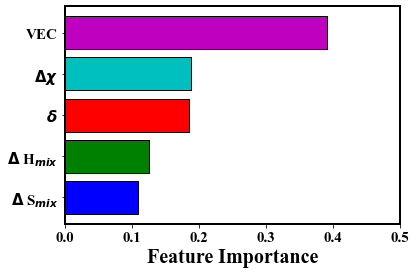

In [38]:
from sklearn.ensemble import ExtraTreesClassifier 
clf = ExtraTreesClassifier(n_estimators=250,
                              random_state=42)

clf.fit(X_train, y_train)
colors = [  'b', 'g','r', 'c','m']

feature_importance = clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig=plt.subplot(1, 1, 1)
rects=plt.barh(pos, feature_importance[sorted_idx],edgecolor = 'black', align='center',color=colors)
fs=[]
yticklabels=['$\Delta$ S$_{mix}$','$\Delta$ H$_{mix}$','$\delta $','$\Delta \chi$','VEC']
for i,v in enumerate(feature_importance):
    fs.append(round(v,3))
    print('Feature: %0d, Score: %.5f' % (i,v))
plt.yticks(pos, yticklabels)
plt.xticks(np.linspace(0,0.5,6))
plt.rcParams['axes.linewidth']=3
plt.xlabel('Feature Importance',fontweight='bold',fontsize=20)
plt.savefig('model1.jpg', dpi=1000,bbox_inches='tight')

#### __4- Model Evaluation-2__
##### 4-1 Learning Curves

In [67]:
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [198]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):
  
    if axes is None:
        _, axes = plt.subplots(1, 2, figsize=(18, 3))

    axes[0].set_title(title,font)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training Examples",font='Times New Roman',fontweight='bold',fontsize=25)
    axes[0].set_ylabel("Score",font='Times New Roman',fontweight='bold',fontsize=25)

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")
    return plt

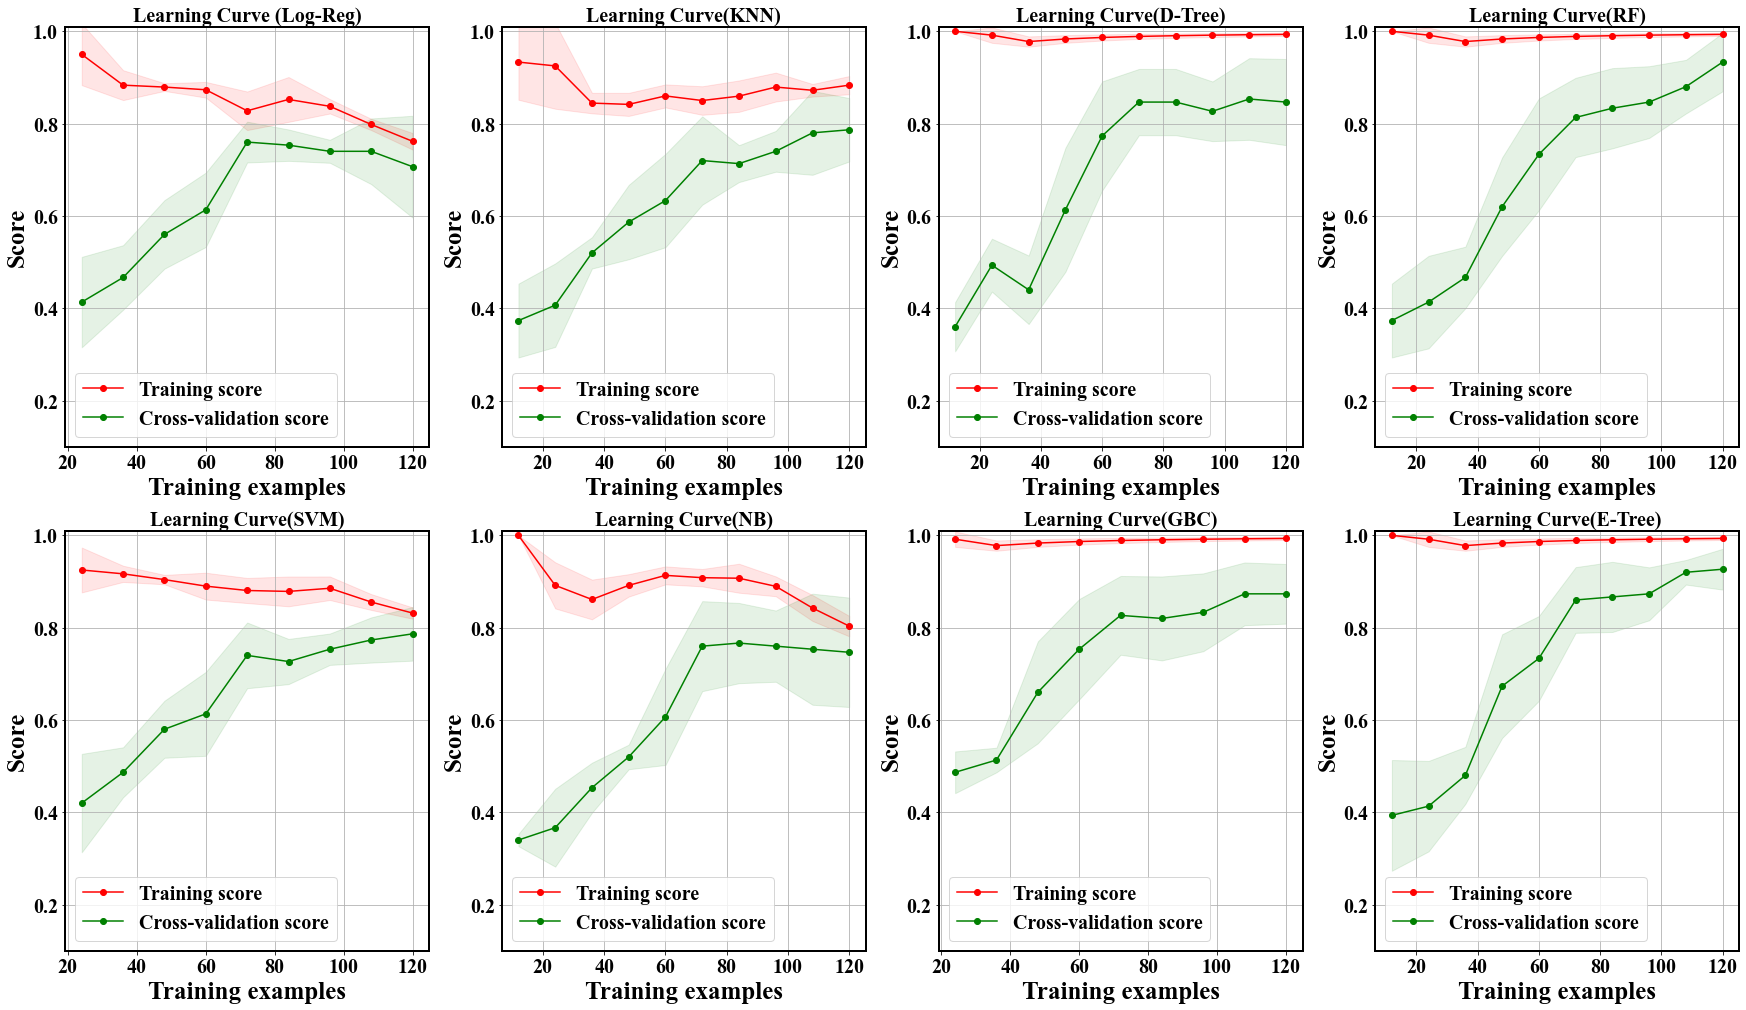

Wall time: 1min 2s


In [96]:
%%time
fig, axes = plt.subplots(2, 4, figsize=(30, 17))
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=SEED)
# use models tuple which already made with optimized hyper-parameters
title = "Learning Curve (Log-Reg)"
plot_learning_curve(models[0][1], title,  X_sm, y_sm, axes=axes[0:1, 0], ylim=(0.1, 1.01), cv=cv, n_jobs=3)

title = "Learning Curve(KNN)"
plot_learning_curve(models[1][1], title,  X_sm, y_sm, axes=axes[0:1, 1], ylim=(0.1, 1.01), cv=cv, n_jobs=3)

title = "Learning Curve(D-Tree)"
plot_learning_curve(models[2][1], title,  X_sm, y_sm, axes=axes[0:1, 2], ylim=(0.1, 1.01), cv=cv, n_jobs=3)

title = "Learning Curve(RF)"
plot_learning_curve(models[3][1], title,  X_sm, y_sm, axes=axes[0:1, 3], ylim=(0.1, 1.01),  cv=cv, n_jobs=3)

title = "Learning Curve(SVM)"
plot_learning_curve(models[4][1], title, X_sm, y_sm, axes=axes[1:2, 0], ylim=(0.1, 1.01),  cv=cv, n_jobs=3)

title = "Learning Curve(NB)"
plot_learning_curve(models[5][1], title, X_sm, y_sm, axes=axes[1:2, 1], ylim=(0.1, 1.01),  cv=cv, n_jobs=3)

title = "Learning Curve(GBC)"
plot_learning_curve(models[6][1], title, X_sm, y_sm, axes=axes[1:2, 2], ylim=(0.1, 1.01),   cv=cv, n_jobs=3)

title = "Learning Curve(E-Tree)"
plot_learning_curve(models[7][1], title, X_sm, y_sm, axes=axes[1:2, 3], ylim=(0.1, 1.01),   cv=cv, n_jobs=3)
plt.savefig('Models100.jpg',dpi=1000,bbox_inches='tight')
plt.tight_layout
plt.show()

There are some important points to consider:
1. For all algorithms, you may notice that training scores are always higher than tests or cross-validation scores(this is almost standard of ML).
2. For logistic regression, SVM,and Naive Bays we see a specific pattern. The Traning data score decreases as examples increase in the training dataset and the validation score is very low(high bias) at the beginning and increases. This pattern can be found in more complex datasets very often.
3. For the rest of the classifiers, we can see that the training score is still around the maximum, and validation could be increased with more new data samples. Comparing with the schematic chart above, we do not see the turning point for the validation curve in these plots meaning we are not in the area of over-fitting at the end of the training. We also can not claim that these classifiers(such as the random forest algorithm) have the highest performance because non of the validation curves did not flatten at the end of the training process.


PREDICTIONS

In [39]:
df2=pd.read_excel(r'predict.xlsx')
df3=df2.drop(['Component'], axis = 1)

In [40]:
df2 = df2.dropna() 

In [41]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5758 entries, 0 to 5757
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Component      5758 non-null   object 
 1   DELTA_R        5758 non-null   float64
 2   DELTA_HmIX     5758 non-null   float64
 3   Delta_Smix     5758 non-null   float64
 4   DELTA_ELECTRO  5758 non-null   float64
 5   VEC            5758 non-null   float64
dtypes: float64(5), object(1)
memory usage: 314.9+ KB


In [42]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5758 entries, 0 to 5757
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DELTA_R        5758 non-null   float64
 1   DELTA_HmIX     5758 non-null   float64
 2   Delta_Smix     5758 non-null   float64
 3   DELTA_ELECTRO  5758 non-null   float64
 4   VEC            5758 non-null   float64
dtypes: float64(5)
memory usage: 225.0 KB


In [45]:
x1=df3
scaler = MinMaxScaler()
x1 = scaler.transform(x1)
df4=pd.DataFrame(x1)
df4

,0,1,2,3,4
0,0.000000,0.750000,0.0,0.059743,0.627907
1,0.017114,0.887097,0.0,0.228661,0.627907
2,0.023673,0.725806,0.0,0.256775,0.604651
3,0.023673,0.911290,0.0,0.059743,0.674419
4,0.034790,0.798387,0.0,0.256775,0.674419
...,...,...,...,...,...
5753,0.999836,0.290323,0.0,0.448674,0.348837
5754,0.999875,0.806452,0.0,0.193433,0.837209
5755,0.999881,0.491935,0.0,0.921561,0.720930
5756,0.999985,0.524194,0.0,0.299080,0.093023


In [ ]:
scaler=

In [40]:
models[7][1]

ExtraTreesClassifier(max_depth=25, n_estimators=350)

In [42]:
ET_model =models[7][1].fit(X_sm,y_sm) 

In [43]:
x=[6.00090414039994,-28.0984000000000,10.7741069393726,0.242844209319473,5.79000000000000]
x = scaler.fit_transform([x])

In [44]:
ET_model.predict(x)

array(['HCP'], dtype=object)

In [45]:
x1=[10.68,-14.4,13.38,0.217,7.8]
x1 = scaler.fit_transform([x1])

In [46]:
ET_model.predict(x1)

array(['HCP'], dtype=object)

In [47]:
x2=[2.035272453,-3.23,8.589310524,0.151413342,8.2]
x2 = scaler.fit_transform([x2])

In [48]:
ET_model.predict(x2)

array(['HCP'], dtype=object)

In [50]:
ET = []
ET_model =models[7][1].fit(X,y) 
for index,row in df4.iterrows():
    ET.append(ET_model.predict([list(row)])[0])
df2["predicted_ET"] =ET

In [49]:
df2.to_excel("Predicted_new.xlsx")

In [70]:
def plot_learning_curve(estimator, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):
  
    fig,ax = plt.subplots(1, 1, figsize=(7,7))

    plt.xlabel("Training Examples",font='Times New Roman',fontweight='bold',fontsize=25)
    plt.ylabel("Accuracy Score",font='Times New Roman',fontweight='bold',fontsize=25)

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = (np.mean(train_scores, axis=1))*100
    train_scores_std = (np.std(train_scores, axis=1))*100
    test_scores_mean = (np.mean(test_scores, axis=1))*100
    test_scores_std = (np.std(test_scores, axis=1))*100
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    leg=plt.legend(loc='lower right',prop={'size':20})
    leg.get_frame().set_edgecolor('k')
    return plt

Wall time: 18.6 s


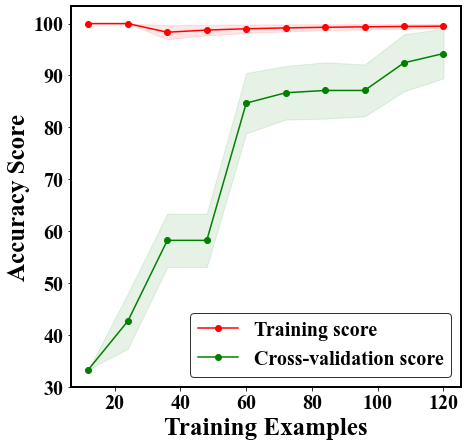

In [72]:
%%time
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=SEED)
plot_learning_curve(models[7][1],  X_sm, y_sm, ylim=(0.1, 1.01), cv=cv, n_jobs=3)
plt.grid(False)
plt.savefig('lr.jpg',bbox_inches='tight')

In [54]:
g =sns.scatterplot(x=df3['VEC'], y=df3["DELTA_ELECTRO"],
              hue="predicted_ET",
              data=df3);

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

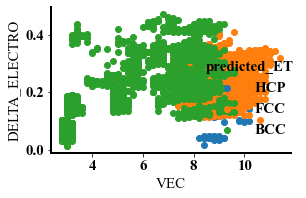

In [62]:
import seaborn as sns 
df=pd.read_excel(r'Predicted_new.xlsx')
fig=sns.FacetGrid(df, hue ="predicted_ET").map(plt.scatter, 'VEC', 'DELTA_ELECTRO').add_legend() 
plt.tight_layout()